# Unsupervised approach for Aspect Based Sentiment Analysis on Restaurant Reviews

We introduce simplest possible approach for unsupervised aspect based sentiment analysis. Here we use word2vec embeddings from spaCy for matching candidate terms from sentences to aspects (classification of aspect terms) and dependency tree parsing using spaCy to detect references of opinion words to aspect terms. Additional list of positive and negative opinion words list is used for classifying sentiment and further analysis of dependencies is used for polarity detection (negations, verbs, adjectives of opinion words, etc).  

# Install Requirements

In [1]:
# !pip install pandas==1.0.3 \
# scikit-learn==0.21.3 \
# scikit-multilearn==0.2.0 \
# neuralcoref==4.0.0 \
# spacy==2.1.0 \
# plotly==4.6.0 \
# gensim==3.8.0 \
# matplotlib==3.1.3 \
# six==1.12.0 \
# numpy==1.16.5 \
# nltk==3.4.5 \
# cython

Download large english model which has word embeddings

In [2]:
# !python -m spacy download en_core_web_lg

# Imports

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
import pandas as pd
import os
import json
import re
import spacy
import matplotlib.pyplot as plt

In [72]:
import warnings
warnings.filterwarnings("ignore")

# Retrieve dataset and parse

Dataset file is xml format. We will parse them using xml library

In [5]:
import xml.etree.ElementTree as ET

Download dataset file from github source link

In [6]:
if not os.path.exists('absa_data'):
    !mkdir absa_data

if not os.path.exists('absa_data/Restaurants_Train.xml'):
    !cd absa_data && wget https://raw.githubusercontent.com/LFCapollo/Aspect-Based-Sentiment-Analysis/master/data/Restaurants_Train.xml

parsing of xml to extract sentences, aspect terms, aspect categories and sentiment polarities

In [7]:
def parse_xml_data(root):
    """Parses xml data to extract aspect terms and aspect categories from each sentence"""
    
    reviews = []

    for sentence in root.findall("sentence"):
        entry = {}
        aspect_terms = []
        aspect_categories = []
        
        if sentence.find("aspectTerms"):
            for aspect_term in sentence.find("aspectTerms").findall("aspectTerm"):
                aspect_terms.append((aspect_term.get("term"), aspect_term.get("polarity")))
                
        if sentence.find("aspectCategories"):
            for aspect_category in sentence.find("aspectCategories").findall("aspectCategory"):
                aspect_categories.append((aspect_category.get("category"), aspect_category.get("polarity")))
                
        entry["text"] = sentence[0].text
        entry["terms"] = aspect_terms
        entry["aspects"] = aspect_categories
        
        reviews.append(entry)

    reviews_df = pd.DataFrame(reviews)
    
    return reviews_df

In [8]:
tree = ET.parse('absa_data/Restaurants_Train.xml')
root = tree.getroot()

In [9]:
df = parse_xml_data(root)

In [10]:
df.head()

,text,terms,aspects
0,But the staff was so horrible to us.,"[(staff, negative)]","[(service, negative)]"
1,"To be completely fair, the only redeeming fact...","[(food, positive)]","[(food, positive), (anecdotes/miscellaneous, n..."
2,"The food is uniformly exceptional, with a very...","[(food, positive), (kitchen, positive), (menu,...","[(food, positive)]"
3,Where Gabriela personaly greets you and recomm...,[],"[(service, positive)]"
4,"For those that go once and don't enjoy it, all...",[],"[(anecdotes/miscellaneous, positive)]"


# EDA

We do simple exploratory data analysis. Data is much cleaner than usual but some additional cleaning can be applied for improving overall results.

## Load spaCy english large model (en_core_web_lg - contains word embeddings also)

load spaCy english model

In [11]:
nlp = spacy.load('en_core_web_lg')

## Count Records

We don't have too much data. Just several thousand records

In [12]:
df.shape[0]

3044

## Show sample values per column

Just to have a look at sample values from each column. As we see we have texts (one or more sentences, aspect terms and aspects with polarity values for both)

In [13]:
for column in df.columns:
    print('='*50)
    print(f'Column: {column.upper()}')
    print('='*50)
    print(f'Values: {df[column].sample(10).values.tolist()}')
    print('-'*50)

Column: TEXT
Values: ['Oh yes, and they lie on the phone, claiming they have seating in the garden, then of course the seats are not available.', 'So my husband made up an excuse so we can leave.', 'My friends and I experienced amazing cheese and a delicious, new summer menu at Artisanal last night.', 'For those prices and the dressed up atmosphere you expect more and should get more.', "I'm no food critic, but I'd like to think I have a tiny bit of experience under my belt having lived in NY for the last 11 years.", 'If you go here - your focus should be the Tamarind Margaritas.', 'I cannot imagine better Indian food in all of the city.', 'A glass of Leaping Lizard, a glass of prosecco, and the mussels had everything happy.', 'The staff makes you feel at home, the food is great and the atmosphere is WONDERFUL!', 'Appetizers are somewhere around $7 each and the main dishes are between $11 and $16.']
--------------------------------------------------
Column: TERMS
Values: [[], [('Decor'

## Aspects

We have just 5 aspect that we need to analyse. (we see later that 'anecdotes/miscellaneous' is kind of hard to analyse with simplest approach and we skip that from evaluation)

In [14]:
set(df.aspects.apply(lambda x: [item[0] for item in x]).sum())

{'ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'}

## Aspects distribution per text/sentence

We have mostly one aspect (sometimes 2 and 3) per text

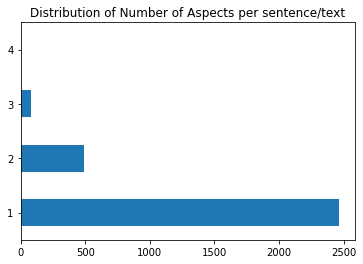

In [15]:
df.aspects.apply(lambda x: len(x)).value_counts().plot(kind='barh', title='Distribution of Number of Aspects per sentence/text');

## Aspects combinations distribution per text/sentence

We further look at all possible combinations of aspects per text

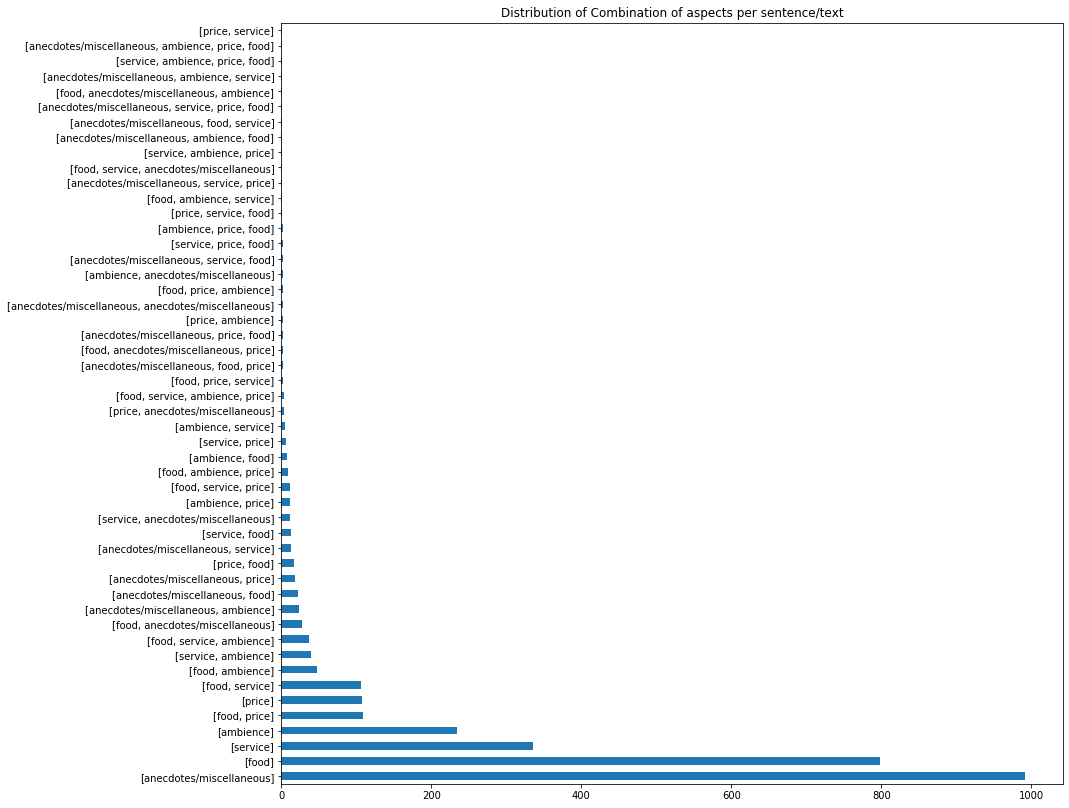

In [16]:
plt.figure(figsize=(14,14))
df.aspects.apply(lambda x:[item[0] for item in x]).value_counts().plot(kind='barh', title='Distribution of Combination of aspects per sentence/text');

## Number of sentences per text

In [17]:
def count_sentences(text):
    return len(list(nlp(text).sents))

In [18]:
count_sentences("I have two sentences here. spaCy must correctly detect the number of sentences.")

2

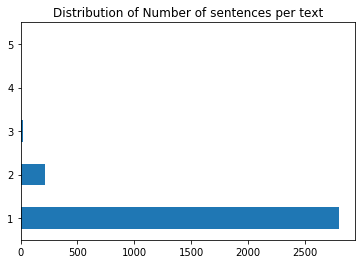

In [19]:
df.text.apply(count_sentences).value_counts().plot(kind='barh', title='Distribution of Number of sentences per text');

# Preprocess Texts

## Coreference Resolution

In [20]:
import neuralcoref

In [21]:
neuralcoref.add_to_pipe(nlp)

In [22]:
def replace_pronouns(text):
    """Replace pronouns in sentences with co-refering nouns"""
    doc = nlp(text)
    return doc._.coref_resolved

In [23]:
replace_pronouns("Anz2 is developer. He is coding right now :).")

'Anz2 is developer. Anz2 is coding right now :).'

In [24]:
df.loc[:, 'text'] = df.text.apply(replace_pronouns)

## Extract Aspect Term Candidates from sentences

We just try to extract aspect term candidates from given text. We take only nouns which are longer than 3 characters.
That candidates aren't used in our approach but just to see and check candidate terms. Similar approach is used for extracting opinion words and referring aspect terms later.

In [25]:
def extract_candidate_terms(text):
    """Extracts all nouns from text as aspect term candidates"""
    
    req_tag = ['NN']
    candidate_terms = []
    
    for token in nlp(text):
        if (
            token.tag_ in req_tag and # token must be noun
            token.shape_ != 'x' and # token mustn't be only one character
            token.shape_ != 'xx' and # token mustn't be only two character
            token.shape_ != 'xxx' # token mustn't be only three character
        ):
            candidate_terms.append(token.lemma_)
            
    return candidate_terms

In [26]:
df.text.iloc[0], extract_candidate_terms(df.text.iloc[0])

('But the staff was so horrible to us.', ['staff'])

In [27]:
df['aspect_term_candidates'] = df.text.apply(extract_candidate_terms)

# Aspect Term Classification

We could classify aspect term candidates using word embedding similarity. We are taking embedding of aspect term candidate, also embeddings of aspects and find maximum match. If it's higher than predefined threshold (hyperparameter which can be tuned in final end-to-end system) we assign given aspect category.

In [28]:
df.head()

,text,terms,aspects,aspect_term_candidates
0,But the staff was so horrible to us.,"[(staff, negative)]","[(service, negative)]",[staff]
1,"To be completely fair, the only redeeming fact...","[(food, positive)]","[(food, positive), (anecdotes/miscellaneous, n...","[factor, food]"
2,"The food is uniformly exceptional, with a very...","[(food, positive), (kitchen, positive), (menu,...","[(food, positive)]","[food, kitchen, food, menu]"
3,Where Gabriela personaly greets you and recomm...,[],"[(service, positive)]",[]
4,"For those that go once and don't enjoy it, all...",[],"[(anecdotes/miscellaneous, positive)]",[]


In [29]:
import numpy as np

In [30]:
class EmbeddingClassifier:
    """Classifying aspect terms into aspects using word embedding similarity"""
    
    def __init__(self, nlp, classes:list, threshold:int=0.4):
        self.classes = classes
        self.class_spans = [nlp(item)[:] for item in classes]
        self.threshold = threshold
        self.nlp = nlp
    
    def predict(self, items:list):
        """Match items to classes using embeddings"""
        predicted_classes = set()
        
        for item in items:
            class_similarities = [
                nlp(item)[:].similarity(class_item) 
                for class_item in self.class_spans
            ]
            max_idx = np.argmax(class_similarities)
            if class_similarities[max_idx] > self.threshold:
                predicted_classes.add(self.classes[max_idx])
        
        return list(predicted_classes)

In [31]:
set(df.aspects.apply(lambda x: [item[0] for item in x]).sum())

{'ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'}

`anecdotes/miscellaneous` is bad aspect category name and will be ignored in our evaluation measurements. It's more general and can't be easily used for measuring vector similarity. To solve such issues we could take several center words for each aspect category like: **food** - **[pizza, drinks, soup, hamburger, fries, etc]** and then measure maximum match between them to decide similarity of aspect term candidate to given aspect category.

In [32]:
aspect_classes = ['ambience', 'miscellaneous', 'food', 'price', 'service']

In [33]:
clf = EmbeddingClassifier(nlp=nlp, classes=aspect_classes, threshold=0.5)

In [34]:
df.head()

,text,terms,aspects,aspect_term_candidates
0,But the staff was so horrible to us.,"[(staff, negative)]","[(service, negative)]",[staff]
1,"To be completely fair, the only redeeming fact...","[(food, positive)]","[(food, positive), (anecdotes/miscellaneous, n...","[factor, food]"
2,"The food is uniformly exceptional, with a very...","[(food, positive), (kitchen, positive), (menu,...","[(food, positive)]","[food, kitchen, food, menu]"
3,Where Gabriela personaly greets you and recomm...,[],"[(service, positive)]",[]
4,"For those that go once and don't enjoy it, all...",[],"[(anecdotes/miscellaneous, positive)]",[]


In [35]:
clf.predict(df.loc[0, 'aspect_term_candidates'])

['service']

In [36]:
clf.predict(df.loc[1, 'aspect_term_candidates'])

['food']

In [37]:
clf.predict(df.loc[2, 'aspect_term_candidates'])

['food']

In [38]:
clf.predict(df.loc[3, 'aspect_term_candidates'])

[]

# Detecting Positive and Negative opinion words in context  

This approach just checks words in opinion words list, so no similarity is used here. We find negative or positive opinion words and then try to find modifiers of given opinion like: **very** `bad` service. Here very is increasing negativeness of `bad` and it refers to service. We store that negative sentiment referring to service and then try to assign aspect category to service using previously explained similarity based approach.

## Get negative and positive English opinion words data 

In [39]:
if not os.path.exists('absa_data/neg_words.txt'):
    !cd absa_data/ && wget https://raw.githubusercontent.com/LFCapollo/Aspect-Based-Sentiment-Analysis/master/data/opinion-lexicon-English/neg_words.txt
if not os.path.exists('absa_data/pos_words.txt'):
    !cd absa_data/ && wget https://raw.githubusercontent.com/LFCapollo/Aspect-Based-Sentiment-Analysis/master/data/opinion-lexicon-English/pos_words.txt

## Parse and Load opinion words

In [40]:
def load_opinions(path:str):
    """Load opinion words from file"""
    opinions = []
    
    with open(path, 'r',  encoding="ISO-8859-1") as file:
        for line in file.readlines():
            if line.strip():
                opinions.append(line.lower().strip())
    
    
    return set(opinions)

In [41]:
negative_words = load_opinions('absa_data/neg_words.txt')
positive_words = load_opinions('absa_data/pos_words.txt')

In [42]:
list(negative_words)[:5]

['passive', 'addicted', 'burn', 'thug', 'conspiratorial']

In [43]:
list(positive_words)[:5]

['fav', 'fervently', 'applaud', 'sparkle', 'delicacy']

## Scoring of feature sentiments using dependency parsing 

HINT: Please use [spacy dependency visualizer](https://explosion.ai/demos/displacy?text=&model=en_core_web_sm&cpu=1&cph=1) to understand examples mentioned here 

In [44]:
def feature_sentiment(sentence:str, pos:set, neg:set):
    """Analyses sentiment of each aspect term in sentence using negative and positive opinion words list"""
    
    sent_dict = dict()
    sentence = nlp(sentence)
    
    for token in sentence:
        # check if the word is an opinion word, then assign sentiment
        if token.text in neg or token.text in pos:
            sentiment = 1 if token.text in pos else -1
            
            # [1] if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            # example: Client eats [amazingly] rotten fruit.
            if (token.dep_ == "advmod"):
                continue
            
            # [2] if target is an adjectival modifier (i.e. bad, great, etc.) 
            # it directly refers to given noun and must assign sentiment of given adjective to given 
            # token head which is modified noun
            # example: Client eats a [rotten] fruit.
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] = sentiment
                
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    
                    # [3] if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    # example: I[like] their service very much.
                    if (
                        (child.dep_ == "amod") or (child.dep_ == "advmod")
                    ) and (
                        child.text in neg or child.text in pos
                    ):
                        sentiment *= 1.5
                        
                    # [4] check for negation words and flip the sign of sentiment
                    # example: I don't [like] their service that much.
                    if child.dep_ == "neg":
                        sentiment *= -1
                
                # [5] in case of VERB we check directly referred objects to directly assign sentiment
                # example: I [like] their service.
                for child in token.children:
                    
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] = sentiment
                        
                        # check for conjugates (a AND b), then add both to dictionary
                        # example: I [like] their service and food.
                        subchildren = []
                        is_conj = False
                        for subchild in child.children:
                            if subchild.text == "and":
                                is_conj = True
                            if is_conj and subchild.text != "and":
                                subchildren.append(subchild.text)
                                is_conj = False
                                
                        for subchild in subchildren:
                            sent_dict[subchild] = sentiment

                # check another childrens of parent in dependency tree 
                for child in token.head.children:
                    
                    if (
                        (child.dep_ == "amod") or (child.dep_ == "advmod")
                    ) and (
                        child.text in neg or child.text in pos
                    ):
                        sentiment *= 1.5
                        
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns and assign sentiment to it (or to compound noun)
                for child in token.head.children:
                    
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        
                        # [7] Check for compound nouns
                        # example: Their entrance door is amazing and beautiful.
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] = sentiment
                    
    return sent_dict

In [45]:
df.text.head().apply(lambda x: feature_sentiment(sentence=x, pos=positive_words, neg=negative_words))

0                        {'staff': -1}
1    {'factor': 1, 'deficiencies': -1}
2            {'food': 1, 'kitchen': 1}
3                                   {}
4                           {'it': -1}
Name: text, dtype: object

# Aspect Based Sentiment Analysis

Implementation of aspect based sentiment analysis class object. It takes text, split into sentences, find aspect term candidates or nouns in sentences and referred sentiments with previously described scoring mechanism. It then assigns aspect categories for each aspect term candidate.

In [46]:
class AspectBasedSentimentAnalyser:
    """Implements aspect based sentiment analysis"""
    
    def __init__(self, nlp, aspects:list, negative_opinions:list, positive_opinions:list, threshold:int):
        self.classifier = EmbeddingClassifier(nlp=nlp, classes=aspects, threshold=threshold)
        self.negative_opinions = negative_opinions
        self.positive_opinions = positive_opinions
        self.nlp = nlp
    
    def analyse(self, text):
        aspect_sentiments = {}
        for sentence in self.nlp(text).sents:
            for feature, sentiment_value in feature_sentiment(
                sentence=sentence.text, pos=self.positive_opinions, neg=self.negative_opinions
            ).items():
                predicted_aspect = self.classifier.predict([feature])
                
                if predicted_aspect:
                    aspect_sentiments[predicted_aspect[0]] = aspect_sentiments.get(predicted_aspect[0], 0) + sentiment_value
        
        return aspect_sentiments

In [47]:
sent_analyser = AspectBasedSentimentAnalyser(
    nlp=nlp,
    aspects=aspect_classes,
    negative_opinions=negative_words,
    positive_opinions=positive_words,
    threshold=0.3
)

In [48]:
df.head(10)

,text,terms,aspects,aspect_term_candidates
0,But the staff was so horrible to us.,"[(staff, negative)]","[(service, negative)]",[staff]
1,"To be completely fair, the only redeeming fact...","[(food, positive)]","[(food, positive), (anecdotes/miscellaneous, n...","[factor, food]"
2,"The food is uniformly exceptional, with a very...","[(food, positive), (kitchen, positive), (menu,...","[(food, positive)]","[food, kitchen, food, menu]"
3,Where Gabriela personaly greets you and recomm...,[],"[(service, positive)]",[]
4,"For those that go once and don't enjoy it, all...",[],"[(anecdotes/miscellaneous, positive)]",[]
5,"Not only was the food outstanding, but the lit...","[(food, positive), (perks, positive)]","[(food, positive), (service, positive)]",[food]
6,It is very overpriced and not very tasty.,[],"[(food, negative), (price, negative)]",[]
7,Our agreed favorite is the orrechiete with sau...,"[(orrechiete with sausage and chicken, positiv...","[(food, positive), (service, positive)]","[favorite, orrechiete, sausage, chicken, dish,..."
8,The Bagels have an outstanding taste with a te...,"[(Bagels, positive)]","[(food, positive)]","[taste, texture]"
9,Nevertheless the food itself is pretty good.,"[(food, positive)]","[(food, positive)]",[food]


In [49]:
df.text.iloc[0], sent_analyser.analyse(df.text.iloc[0])

('But the staff was so horrible to us.', {'service': -1})

In [50]:
df.text.iloc[1], sent_analyser.analyse(df.text.iloc[1])

("To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.",
 {'price': 1})

In [51]:
df.text.iloc[2], sent_analyser.analyse(df.text.iloc[2])

("The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether The food's on the menu or not.",
 {'food': 2})

In [52]:
df.text.iloc[3], sent_analyser.analyse(df.text.iloc[3])

('Where Gabriela personaly greets you and recommends you what to eat.', {})

In [53]:
df.text.iloc[4], sent_analyser.analyse(df.text.iloc[4])

("For those that go once and don't enjoy it, all I can say is that those that go once and don't enjoy it just don't get it.",
 {'food': -1})

In [54]:
df.text.iloc[5], sent_analyser.analyse(df.text.iloc[5])

("Not only was the food outstanding, but the little 'perks' were great.",
 {'food': 1})

In [55]:
df.text.iloc[9], sent_analyser.analyse(df.text.iloc[9])

('Nevertheless the food itself is pretty good.', {'food': 1.5})

# Evaluation of results

We simply calculate confusion matrix values with custom functions to consider specific cases.

In [56]:
def convert_prediction(prediction):
    return [
        (
            item if item!='miscellaneous' else 'anecdotes/miscellaneous', "positive" if value > 0 else 'neutral' if value==0 else "negative"
        ) for item, value in prediction.items()
    ]

In [57]:
convert_prediction({'miscellaneous': -1})

[('anecdotes/miscellaneous', 'negative')]

In [58]:
convert_prediction({'food': 0})

[('food', 'neutral')]

In [59]:
def confusion_value(label, prediction):
    result = None
    if not label:
        if not prediction:
            result = 'TN'
        else:
            result = 'FP'
    else:
        if not prediction:
            result = 'FN'
        else:
            converted_prediction = convert_prediction(prediction)
            result = 'TP'
            for item in label:
                if item in converted_prediction or item[0] == 'anecdotes/miscellaneous':
                    pass
                else:
                    result = 'FN'
                    break
        
    return result

In [60]:
def confusion_matrix_values(labels, predictions):
    confusion_matrix = {}
    
    for label, prediction in zip(labels, predictions):
        conf_value = confusion_value(label, prediction)
        confusion_matrix[conf_value] = confusion_matrix.get(conf_value, 0) + 1
    
    return confusion_matrix

In [61]:
df.aspects.head()

0                                [(service, negative)]
1    [(food, positive), (anecdotes/miscellaneous, n...
2                                   [(food, positive)]
3                                [(service, positive)]
4                [(anecdotes/miscellaneous, positive)]
Name: aspects, dtype: object

In [62]:
pd.Series(sent_analyser.analyse(text) for text in df.text.head())

0    {'service': -1}
1       {'price': 1}
2        {'food': 2}
3                 {}
4       {'food': -1}
dtype: object

In [73]:
df.loc[:, 'aspect_predictions'] = df.text.apply(sent_analyser.analyse)

In [64]:
conf_matrix = confusion_matrix_values(df.aspects.values.tolist(), df.aspect_predictions.values.tolist())

In [65]:
conf_matrix

{'TP': 817, 'FN': 2227}

As we see we don't have false positive cases and true negative cases. That can be simply explained. False positive isn't available because we are using fixed set of opinion words which keeps us from using false opinion words. Also we are lacking of text samples without classified sentiments.

Accuracy of our system is quite low but we have 100% precision and just recall is low. It can be improved with more advanced approaches. Here we used simplest possible approach which is easily adaptable to any case and what we need to make this work is to list aspect categories.

# Visualize Aspect Based Sentiment Analysis Results

Visualisation of aspect sentiments is done with positive, neutral and negative cases only (`contradiction` categories are missing to avoid misconfusions)

In [67]:
def summary_aspect_based_sentiment_analysis(predictions):
    summary = {}
    for prediction in predictions:
        if prediction:
            for aspect, sentiment in convert_prediction(prediction):
                if aspect not in summary:
                    summary[aspect] = {}

                summary[aspect][sentiment] = summary[aspect].get(sentiment, 0) + 1
    
    return summary

In [68]:
summary = summary_aspect_based_sentiment_analysis(df.aspect_predictions.values.tolist())

In [69]:
summary

{'service': {'negative': 95, 'positive': 298, 'neutral': 3},
 'price': {'positive': 105, 'negative': 36, 'neutral': 1},
 'food': {'positive': 817, 'negative': 188, 'neutral': 38},
 'ambience': {'positive': 145, 'negative': 28, 'neutral': 2},
 'anecdotes/miscellaneous': {'negative': 2, 'positive': 4}}

<Figure size 1008x1008 with 0 Axes>

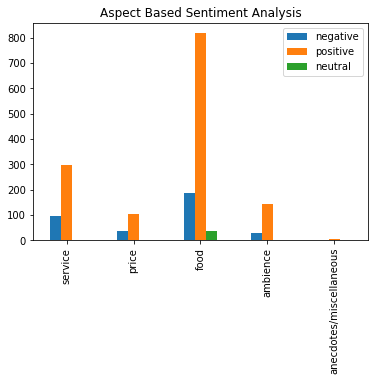

In [70]:
plt.figure(figsize=(14,14));
pd.DataFrame(summary).T.plot(kind='bar', title='Aspect Based Sentiment Analysis');

# References

[Nika Kvedelidze Sample Project at MaxinAI](https://github.com/LFCapollo/Aspect-Based-Sentiment-Analysis)

[Intellica.AI - ABSA blog](https://medium.com/@Intellica.AI/aspect-based-sentiment-analysis-everything-you-wanted-to-know-1be41572e238)

[remicnrd - ABSA blog](https://remicnrd.github.io/Aspect-based-sentiment-analysis) - ideas